In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit

# Load weak labeled data
df = pd.read_csv("/Users/cibylin/Desktop/captsone_github/weak_labeled_data(1).csv") 

df = df[df["weak_label"] >= 0]

df["log_review_count"] = np.log1p(df["review_count"])

# Feature engineering
features = ["similarity", "rating", "log_review_count",
    "city_match", "category_match_score", "transaction_match_score",
    "open_overnight_score", "price_score"] 
X = df[features]
y = df["weak_label"]
groups = df["query_id"]

# Group-aware train/test split
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
group_train = groups.iloc[train_idx]
group_test = groups.iloc[test_idx]

train_group = group_train.value_counts(sort=False).sort_index().tolist()
test_group = group_test.value_counts(sort=False).sort_index().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.set_group(train_group)

dtest = xgb.DMatrix(X_test, label=y_test)
dtest.set_group(test_group)

params = {
    "objective": "rank:ndcg",
    "eval_metric": "ndcg",
    "learning_rate": 0.05,
    "max_depth": 5,
    "min_child_weight": 10, 
    "gamma": 1.0,  
    "subsample": 0.8,  
    "colsample_bytree": 0.8
}

model = xgb.train(params, dtrain, num_boost_round=200)

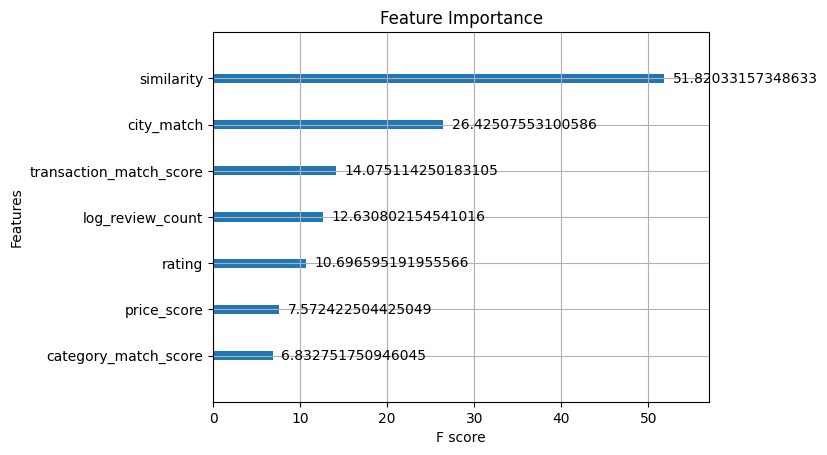

In [13]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("Feature Importance")
plt.show()

In [14]:
# Save the model
model.save_model("lambdamart_ranking_model(1).json")

# Predict ranking scores
y_pred = model.predict(dtest)

# Save predicted ranking
df_test = df.iloc[test_idx].copy()
df_test["predicted_score"] = y_pred
df_test = df_test.sort_values(by=["query_id", "predicted_score"], ascending=[True, False])

# Save to CSV
df_test.to_csv("ranked_results.csv", index=False)

In [15]:
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=10
)

[0]	train-ndcg:0.85828	test-ndcg:0.76936
[10]	train-ndcg:0.97773	test-ndcg:0.96104
[19]	train-ndcg:0.96306	test-ndcg:0.89716


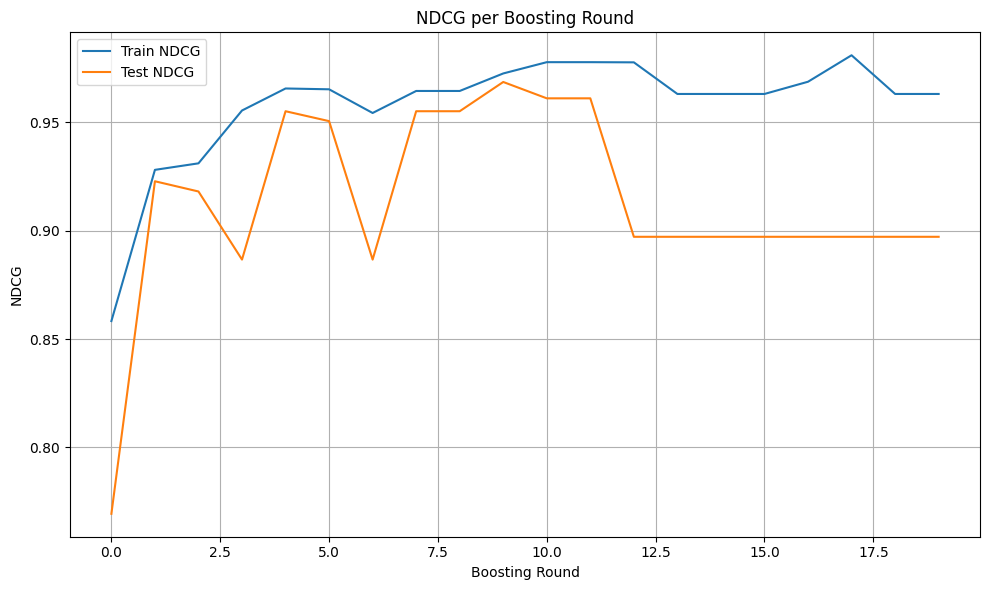

In [16]:
import matplotlib.pyplot as plt

# Extract the results
train_ndcg = evals_result["train"]["ndcg"]
test_ndcg = evals_result["test"]["ndcg"]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_ndcg, label="Train NDCG")
plt.plot(test_ndcg, label="Test NDCG")
plt.xlabel("Boosting Round")
plt.ylabel("NDCG")
plt.title("NDCG per Boosting Round")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()